In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp trait

## Trait
> contains logic for quantitative traits

In [ ]:
#|export

from chewc.core import *
import torch
import attr
from typing import Tuple, Optional, List
from fastcore.test import *
import matplotlib.pyplot as plt
import torch.nn as nn
import pdb

def select_qtl_loci(num_qtl_per_chromosome: int, genome: Genome) -> torch.Tensor:
    """
    Randomly selects loci to be QTLs on each chromosome.

    Args:
    ----
    num_qtl_per_chromosome (int): Number of QTLs to select per chromosome.
    genome (Genome): Genome object containing the chromosome structure.
    device (str): Device to create the tensor on ('cpu' or 'cuda'). Defaults to 'cpu'.

    Returns:
    -------
    torch.Tensor: A boolean tensor indicating which loci are QTLs. 
                  Shape: (number_chromosomes, loci_per_chromosome)
    """
    
    assert num_qtl_per_chromosome <= genome.n_loci_per_chromosome, "too many qtls for this trait given your Genome object"
    assert num_qtl_per_chromosome > 0, "you need at least 1 QTL per chromosome"
    
    qtl_indices = []
    for i in range(genome.n_chromosomes):
        # Randomly sample indices for QTLs on the current chromosome
        chromosome_indices = torch.randperm(genome.n_loci_per_chromosome)[:num_qtl_per_chromosome]
        
        # Create a boolean tensor for the current chromosome, marking QTL positions as True
        chromosome_qtl_flags = torch.zeros(genome.n_loci_per_chromosome, dtype=torch.bool)
        chromosome_qtl_flags[chromosome_indices] = True
        
        qtl_indices.append(chromosome_qtl_flags)
    
    return torch.stack(qtl_indices)

class TraitA(nn.Module):

    
    def __init__(self, genome: Genome, founder_population: Population, target_mean: float, target_variance: float):
        super().__init__()
        self.genome = genome
        self.target_mean = torch.tensor(target_mean, device=self.genome.device)
        self.target_variance = torch.tensor(target_variance, device=self.genome.device)
        self.effects = None  # QTL effects (to be initialized later)
        self.intercept = None
        self.qtl_map =  torch.randint(0, 2, (self.genome.n_chromosomes, self.genome.n_loci_per_chromosome), device=self.genome.device) # random qtl map
        
        # Move computations to the GPU for performance
        with torch.no_grad(): 
            self.sample_initial_effects()
            self.scale_effects(founder_population)

    def _calculate_scaled_additive_dosages(self, genotypes: torch.Tensor) -> torch.Tensor:

        return (genotypes - self.genome.ploidy / 2) * (2 / self.genome.ploidy)

    def sample_initial_effects(self):

        self.effects = torch.randn((self.genome.n_chromosomes, self.genome.n_loci_per_chromosome), device=self.genome.device) 

    def scale_effects(self, founder_pop: Population):

        founder_genotypes = founder_pop.get_dosages().float().to(self.genome.device)  # Move to GPU
        scaled_dosages = self._calculate_scaled_additive_dosages(founder_genotypes)
        # Apply QTL map
        scaled_dosages = scaled_dosages * self.qtl_map[None, None, :, :]  
        genetic_values = torch.sum(scaled_dosages * self.effects[None, None, :, :], dim=(2, 3))
        current_mean = genetic_values.mean()
        self.intercept = self.target_mean - current_mean
        initial_variance = torch.var(genetic_values)
        scaling_constant = torch.sqrt(self.target_variance / initial_variance)
        self.effects = self.effects * scaling_constant
        # Intercept is now fixed to the target mean
        
#         current_mean = self.calculate_genetic_values(self.sim_param.founder_pop).mean()
#         self.intercept = self.target_mean - current_mean

    def forward(self, genotypes: torch.Tensor) -> torch.Tensor:

        genotypes = genotypes.to(self.genome.device) # Ensure genotypes are on the same device as effects
        scaled_dosages = self._calculate_scaled_additive_dosages(genotypes)
        # Apply QTL map
        scaled_dosages = scaled_dosages * self.qtl_map
        genetic_values = torch.sum(scaled_dosages * self.effects[None, None, :, :], dim=(2, 3)) + self.intercept
        return genetic_values

In [ ]:
import torch

ploidy=2
n_chr=10
n_loci=1000
g = Genome(ploidy,n_chr,n_loci)
population = Population()
population.create_random_founder_population(g, n_founders=50)
init_pop = population.get_dosages().float() #gets allele dosage for calculating trait values

#Trait A Class
target_means = torch.tensor([0,5,20])
target_vars = torch.tensor([1,2,5])
n_traits = target_means.shape[0]
correlation_values = [
    [1.0, 0.2, 0.58],
    [.2, 1.0, -0.37],
    [0.58, -0.37, 1.0]
]

corA = torch.tensor(correlation_values)
L = torch.linalg.cholesky(corA)

# Sample initial additive effects from a standard normal distribution
correlated_effects = torch.randn(n_chr, n_loci, n_traits)

# Reshape for proper multiplication with Cholesky factor
correlated_effects = correlated_effects.reshape(n_chr * n_loci, n_traits)
correlated_effects = torch.matmul(L, correlated_effects.T).T
correlated_effects = correlated_effects.reshape(n_chr, n_loci, n_traits)

unscaled_bvs = torch.einsum('ijk,lij->lk', correlated_effects, init_pop) 
unscaled_var = unscaled_bvs.var(dim=0)
unscaled_mean = unscaled_bvs.mean(dim=0)
trait_intercepts = []

# Scale correlated effects and calculate intercepts
for i in range(n_traits):
    scaling_factor = torch.sqrt(target_vars[i] / unscaled_var[i])
    correlated_effects[:, :, i] *= scaling_factor
    trait_intercepts.append(target_means[i] - (unscaled_mean[i] * scaling_factor))

trait_intercepts = torch.tensor(trait_intercepts)

Created genetic map


<matplotlib.collections.PathCollection>

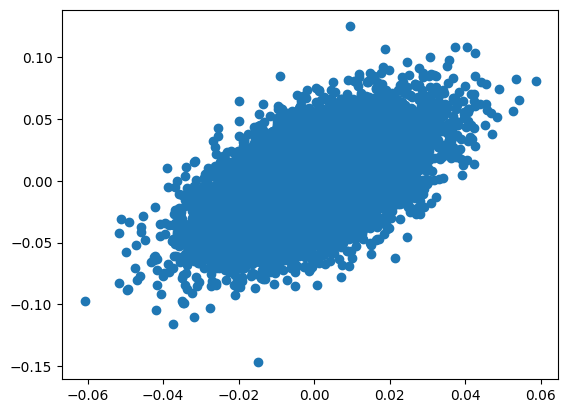

In [ ]:
plt.scatter(correlated_effects[:,:,0],correlated_effects[:,:,2])

<matplotlib.collections.PathCollection>

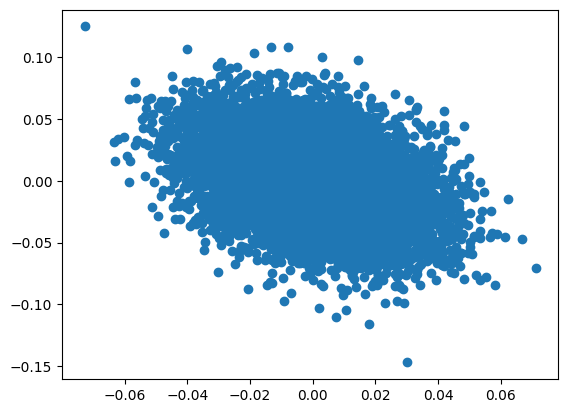

In [ ]:
plt.scatter(correlated_effects[:,:,1],correlated_effects[:,:,2])

In [ ]:
scaled_bvs = torch.einsum('ijk,lij->lk', correlated_effects, init_pop)

<matplotlib.collections.PathCollection>

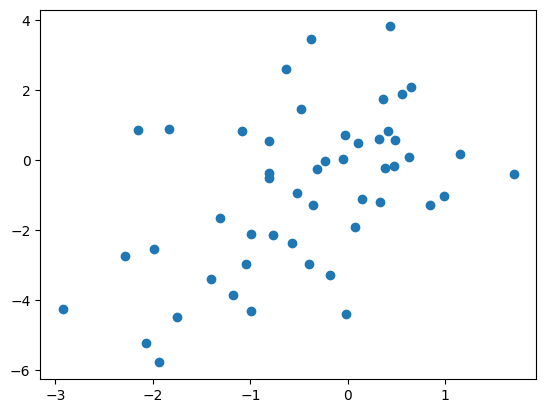

In [ ]:
plt.scatter(scaled_bvs[:,0],scaled_bvs[:,2])

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()